# Data Modelisation

- Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from nlp_module import remove_stopwords, plot_top_words, tok, print_score
import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
sklearn.set_config(display="diagram")

## 1) Data preparation

In [3]:
path = "datasets/posts_clean.csv"

In [4]:
data = pd.read_csv(path, encoding="utf-8")
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,I use python year I little experience python w...,<python><web-services>
1,415344,log implementation prefer,I implement log class c try decide I curious k...,<debugging><language-agnostic><logging>
2,414981,directly modify list element,I struct struct map public int size public map...,<c#><.net>


Missing data will be inspected. Indeed, we haven't watched missing values for titles yet. 

In [5]:
data.isnull().mean()

Id       0.000000
Title    0.000061
Body     0.000000
Tags     0.000000
dtype: float64

Missing values for titles represent less than 1% of our dataset. We can delete them. 

In [6]:
data.dropna(inplace=True)

Our data is composed by title of the posts, body and associated tags. As we can see, our data needs a bit of preprocessing. In one hand, signs "<" and ">" will be remove and in other hand, texts inside body will be written in lower case and stopwords will be removed. 

In [7]:
# remove < and > around Tags
data["Tags"] = data["Tags"].replace({"<" : ""}, regex=True)
data["Tags"] = data["Tags"].replace({">" : ","}, regex=True)
data["Tags"] = data["Tags"].str.rstrip(',')

In [8]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

In [9]:
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,"python,web-services"
1,415344,log implementation prefer,implement log class c try decide curious know ...,"debugging,language-agnostic,logging"
2,414981,directly modify list element,struct struct map public int size public map i...,"c#,.net"


Our dataset is ready for the next step. Before, data will be resampling. In order to accelerate the modeling's stages, only 10% of our data will be used.

In [10]:
data = data.sample(frac=0.05, random_state=42)

Moreover, we decide to consider title and body as a whole text. We aggregate these data in a new variable nammed "docs". 

In [11]:
docs = data["Title"].values + " " + data["Body"].values

Finally, we can vectorize our data. In order to realise a first classification with NMF, the chosen vectorizer is TF-IDF. The sparsicity of our vectorized data is evaluated. 

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [13]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.41 %


Sparsicity is less than 1%.

## 2) Topic Modelling

Topic Modelling is an unsupervised method. These methods are used in order to find a classification inside our text. 

### a) Non Negative Matrix Factorization (NMF)

In [14]:
best_num_topics = 10

In [15]:
nmf = NMF(n_components=best_num_topics,
          random_state=42,
          alpha=0.1)

In [16]:
nmf.fit(tfidf)

NMF(alpha=0.1, n_components=10, random_state=42)

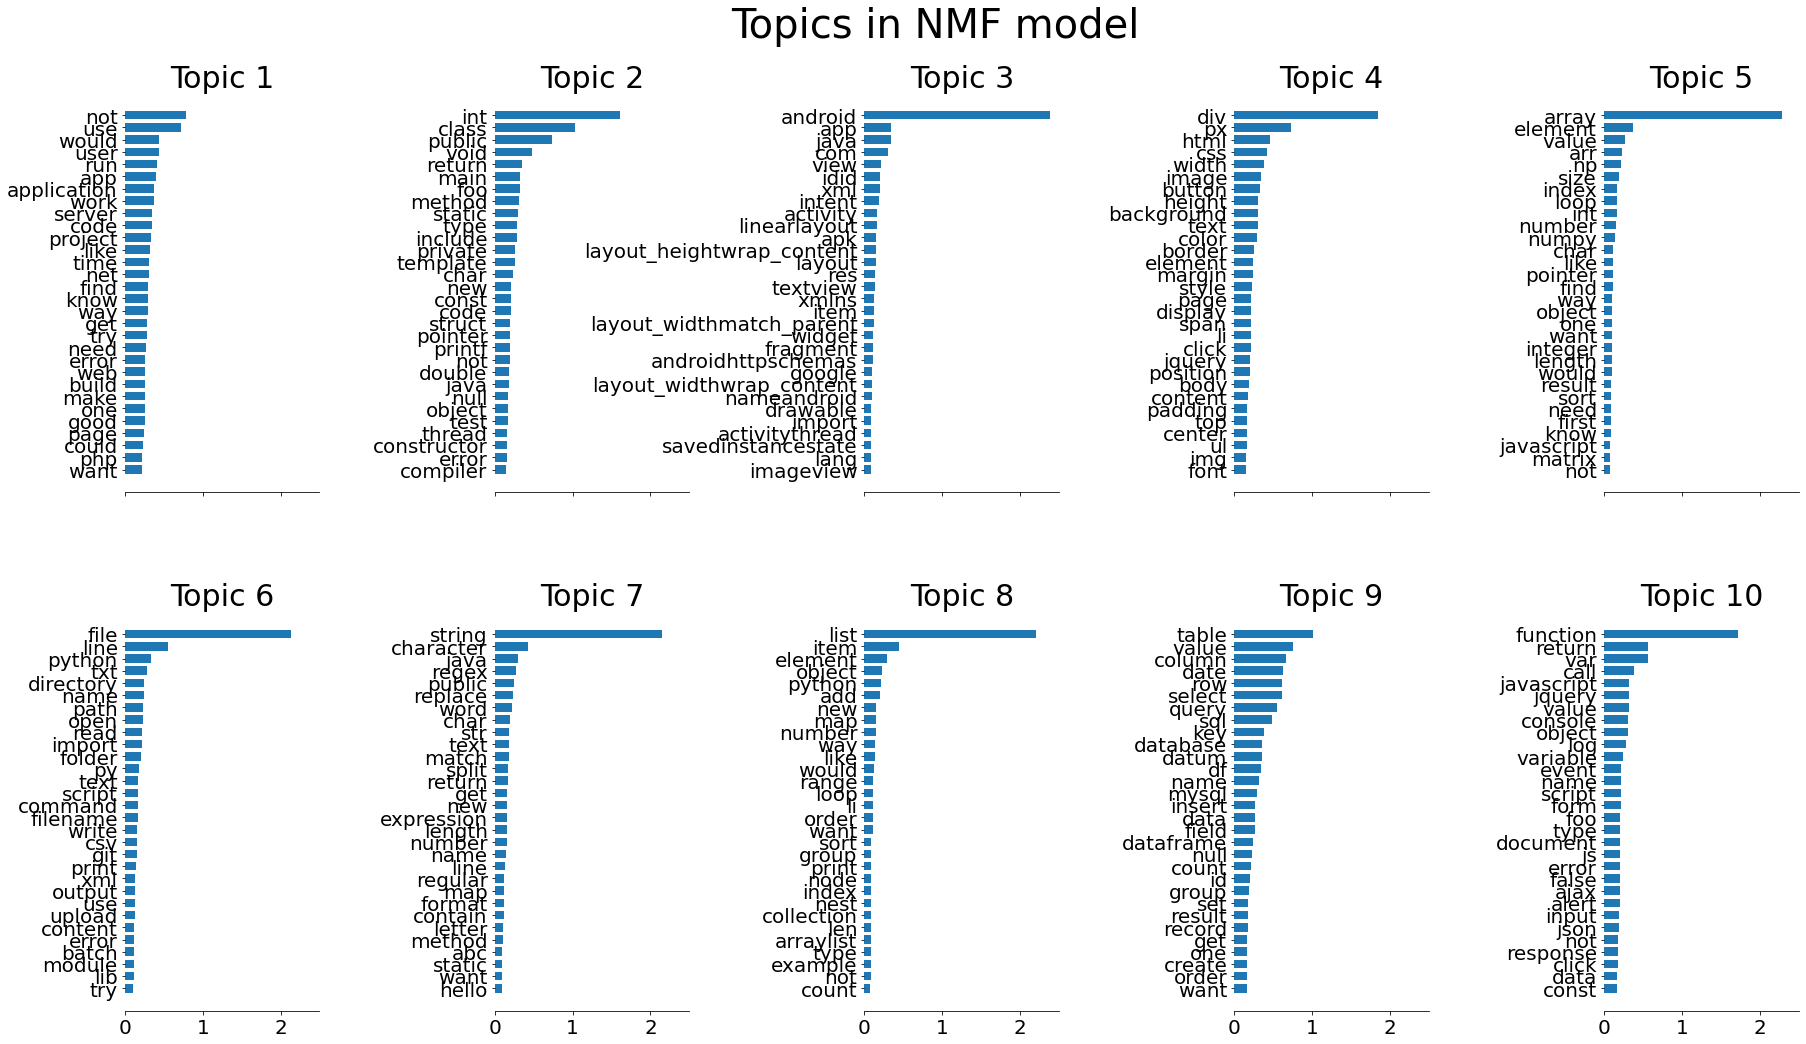

In [17]:
plot_top_words(nmf, tfidf_feature_names, n_top_words=30, title="Topics in NMF model")

In [18]:
del nmf
gc.collect()

59160

### b) Latent Dirichlet Allocation (LDA)

In [19]:
bow_vectorizer = CountVectorizer(ngram_range = (1,1),
                                 tokenizer=tok)
docs_bow = bow_vectorizer.fit_transform(docs)

In [20]:
lda = LatentDirichletAllocation(random_state=42,
                                batch_size=400)

In [21]:
params = {'n_components' : [8, 9, 10],
          "learning_decay" : [0.5, 0.7, 0.9],
          "learning_method" : ["batch", "online"]}

gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5,
                              verbose=2)
gridsearch_lda.fit(docs_bow)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  26.3s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  25.1s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  25.7s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  25.9s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  25.9s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  25.8s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  25.3s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  25.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  24.7s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  25.3s
[CV] END learning_decay=0.5, learning_method=batch, n_components=10; 

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(batch_size=400,
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [8, 9, 10]},
             verbose=2)

In [22]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)
print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 8}
Best Log Likelihood Score:  -1865486.1602541003


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, docs_bow, bow_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -108.958252 -208.941483       1        1  66.777140
6      186.487061  -98.103249       2        1   9.502024
7       19.245832  160.858780       3        1   8.751560
3      170.658829   75.445076       4        1   5.039833
0       -1.386411  -35.043739       5        1   3.432247
2     -145.800095  106.944611       6        1   2.934858
4       64.834541 -221.825272       7        1   1.795928
1     -196.906036  -58.990913       8        1   1.766410, topic_info=          Term          Freq         Total Category  logprob  loglift
414          ]  15418.000000  15418.000000  Default  30.0000  30.0000
2            [  10262.000000  10262.000000  Default  29.0000  29.0000
2853   android   3744.000000   3744.000000  Default  28.0000  28.0000
30492     java   3528.000000   3528.000000  Default  27.0000  27.0000
479          _   4722.000000   4722.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
20019    field     26.555510    865.488299   Topic8  -6.4624   0.5522
50131   select     25.202260   1361.551491   Topic8  -6.5147   0.0468
55851    table     22.047428   1765.589355   Topic8  -6.6484  -0.3468
12297  convert     20.647242    598.281675   Topic8  -6.7140   0.6697
13311      csv     20.032055    259.815790   Topic8  -6.7443   1.4736

[600 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
0          2  0.015675         &#9
0          4  0.981808         &#9
1          2  0.015675           ;
1          4  0.981816           ;
2          1  0.852578           [
...      ...       ...         ...
64529      7  0.155353         yes
64529      8  0.003789         yes
64688      2  0.030274  zclpayload
64688      6  0.938482  zclpayload
64855      3  0.991438  zygoteinit

[1672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 8, 4, 1, 3, 5, 2])

- Topic 1 : OS - Top topic
- Topic 2 : Script Language/Python
- Topic 3 : Web language/Front-end
- Topic 4 : Java
- Topic 5 : Web language/Back-end
- Topic 6 : SQL
- Topic 7 : Script Language

In [24]:
del lda
gc.collect()

61

### c) Evaluation of topic modelling

In [25]:
warnings.filterwarnings("ignore")

from gensim.corpora.dictionary import Dictionary

dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

In [26]:
from gensim.models import Nmf

nmf = Nmf(corpus, num_topics=10, id2word=common_dictionary)

In [27]:
from gensim.models.ldamodel import LdaModel

lda = LdaModel(corpus, num_topics=8, id2word=common_dictionary)

In [28]:
from gensim.models.coherencemodel import CoherenceModel

cm_nmf = CoherenceModel(model=nmf, texts=dataset, corpus=corpus, coherence='c_v')
coherence_nmf = cm_nmf.get_coherence()
cm_lda = CoherenceModel(model=lda, texts=dataset, corpus=corpus, coherence='c_v')
coherence_lda = cm_lda.get_coherence()

In [29]:
print("Coherence Model - NMF: ", coherence_nmf.round(3))
print("Coherence Model - LDA: ", coherence_lda.round(3))

Coherence Model - NMF:  0.354
Coherence Model - LDA:  0.413


## 3) Supervised learning for text classification

### a) Data preparation

In [51]:
tags = data["Tags"].apply(lambda x: x[0:].split(','))

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tags_mlb = mlb.fit_transform(tags)

In [53]:
list(mlb.classes_)

['.doc',
 '.htaccess',
 '.net',
 '.net-2.0',
 '.net-3.5',
 '.net-4.0',
 '.net-4.0-beta-2',
 '.net-5',
 '.net-assembly',
 '.net-core',
 '.net-core-3.0',
 '.net-core-3.1',
 '.net-remoting',
 '2captcha',
 '2d',
 '3-tier',
 '32-bit',
 '32bit-64bit',
 '3d',
 '3nf',
 '64-bit',
 'aabb',
 'aac',
 'aar',
 'abap',
 'abbreviation',
 'abi',
 'absolute',
 'absolute-path',
 'abstract',
 'abstract-class',
 'abstract-syntax-tree',
 'abstraction',
 'access-token',
 'access-violation',
 'accesscontrolexception',
 'accessibility',
 'ack',
 'acl',
 'action',
 'action-filter',
 'actioncontroller',
 'actionmailer',
 'actionresult',
 'actionscript',
 'actionscript-3',
 'activation',
 'active-directory',
 'active-relation',
 'activeadmin',
 'activemq',
 'activerecord',
 'activesupport',
 'activiti',
 'activity-finish',
 'ada',
 'adapter',
 'adb',
 'add',
 'addeventlistener',
 'addition',
 'addrange',
 'address-operator',
 'address-space',
 'addressbook',
 'addtextchangedlistener',
 'admob',
 'ado',
 'ado.net'

In [54]:
from sklearn.model_selection import train_test_split

X = docs
y = tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

In [55]:
vectorizer = TfidfVectorizer(ngram_range =(1,1),
                            tokenizer=tok,
                            max_features=12000)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

In [56]:
X_test_vec = vectorizer.transform(X_test)

### b) Naive Bayes Classifier

In [57]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, 
                                           class_prior=None))
nb_clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [58]:
y_pred_nb = nb_clf.predict(X_test_vec)

In [37]:
from nlp_module import print_score

In [59]:
print_score(y_test, y_pred_nb)

Hamming loss (Misclassification Ratio): 0.0006171473691517423
Label-Based Accuracy: 0.004122125040492387
Subset Accuracy:  0.00048590864917395527
F1-score Micro:  0.00761059140637387
F1-Score Macro:  8.02731108944942e-05


- Grid Search

In [40]:
from sklearn.metrics import make_scorer, accuracy_score

scorer_multilabel = make_scorer(accuracy_score,
                                normalized=True,
                                sample_weight=None)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {"estimator__alpha": [0.3, 0.5, 0.7, 0.9, 1.0]}

gridsearch_nb = GridSearchCV(estimator=nb_clf, 
                             param_grid=params, 
                             scoring=scorer_multilabel,
                             cv=5,
                             verbose = 2)
gridsearch_nb.fit(X_train_vec, y_train)

In [ ]:
gridsearch_nb.best_estimator_

In [ ]:
gridsearch_nb.best_params_

In [ ]:
best_model_nb = gridsearch_nb.best_estimator_

In [ ]:
del y_pred_nb
gc.collect()

- Model Evaluation

In [ ]:
y_pred_nb = best_model_nb.predict(X_test_vec)

In [ ]:
print_score(y_test, y_pred_nb)

### c) Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svm_clf = OneVsRestClassifier(SVC(random_state=42))
svm_clf.fit(X_train_vec, y_train)

In [ ]:
y_pred_svm = svm_clf.predict(X_test_vec)

In [ ]:
print_scores(y_test, y_pred_svm)

In [ ]:
del y_pred_svm
gc.collect()

## 4) Machine Learning for Multilabel Classification

### a) Algorithm Adaptation approaches

In [ ]:
X_train_vec = X_train_vec.toarray()
y_train = np.array(y_train)

In [ ]:
X_test_vec = X_test_vec.toarray()
y_test = np.array(y_test)

- Multilabel KNN

In [ ]:
from skmultilearn.adapt import MLkNN

mlknn_clf = MLkNN()
mlknn_clf.fit(X_train_vec, y_train)

In [ ]:
y_pred = mlknn_clf.predict(X_test_vec)
print_scores(y_test, y_pred)

In [ ]:
parameters = {'k': range(6,12), 
              's': [0.7, 1.0]}


gridsearch_mlknn = GridSearchCV(mlknn_clf, 
                   parameters, 
                   scoring=scorer_multilabel, 
                   verbose=2)
gridsearch_mlknn.fit(X_train_vec,
                     y_train)

In [ ]:
gridsearch_mlknn.best_params_

In [ ]:
best_model_mlknn = gridsearch_mlknn.best_estimator_

In [ ]:
del y_pred
gc.collect()

In [ ]:
y_pred = best_model_mlknn.predict(X_test_vec)
print_scores(y_test, y_pred)

In [ ]:
del data
del tags_mlb
del tags
del y_pred
gc.collect()

## 5) Deep Learning for text classification

### a) Data Preparation

In [ ]:
data = pd.read_csv(path, encoding="utf-8")
data.head(3)

In [ ]:
# remove < and > around Tags
data["Tags"] = data["Tags"].replace({"<" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({">" : ","}, regex=True)
data["Tags"] = data["Tags"].str.rstrip(',')

In [ ]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data = data.sample(frac=0.05, random_state=42)

In [ ]:
docs = data["Title"].values + " " + data["Body"].values

In [ ]:
tags = data["Tags"].apply(lambda x: x[1:-1].split(','))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

tags_mlb = mlb.fit_transform(tags)

In [ ]:
list(mlb.classes_)

In [ ]:
from sklearn.model_selection import train_test_split

X = docs
y = tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import convert_to_tensor

In [ ]:
max_sequence_length = 300

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=12000, output_sequence_length=300)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Bidirectional, Dense, Embedding, Flatten, InputLayer, LSTM
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam, Nadam

In [ ]:
vocab_size = 12000
embedding_dim = 64
max_length = 300

### b) Words Embedding: Introducing GloVe

In [ ]:
path_to_glove_file = 'datasets/glove.840B.300d.txt'

In [ ]:
warnings.filterwarnings("ignore")

embeddings_index = {}
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_vector = embedding_matrix[i]
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

### c) Building Model

In [ ]:
def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(max_length, )))
    model.add(Embedding(num_tokens,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=False))
    model.add(LSTM(embedding_dim, 
                   activation="tanh",
                   return_sequences=True))
    model.add(LSTM(embedding_dim, 
                   activation="tanh",
                   return_sequences=True))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(0.001))
    return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='illustrations/lstm.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=2)

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print_scores(y_test, y_pred)

In [ ]:
print(mlb.inverse_transform(y_pred))

In [ ]:
print(mlb.inverse_transform(y_test))

### d) Tuning Hyperparameters

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(max_length, )))
    model.add(Embedding(num_tokens,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=False))
    model.add(LSTM(units = hp.Int(
                                'LSTM_1_units', 
                                min_value=32, 
                                max_value=512, 
                                step=32),
                   activation = "tanh")
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], 
                    activation = hp.Choice("activation_function",
                                           values=['sigmoid', "softmax"])))
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  metrics = ['accuracy'])
    return model

In [ ]:
warnings.filterwarnings("ignore")

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=False,
    seed = 42,
    directory="output",
    project_name="optimization_LSTM"
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train, epochs=2, validation_split=0.1)

In [ ]:
tuner.results_summary()

**References**

- https://colah.github.io/posts/2015-08-Understanding-LSTMs/